In [1]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']
GENECNV_COLUMNS = ['patientName','gene','chrom','posStart','posEnd','minCopyNum','cnvLabel']

In [4]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"  #HMF_Slicing.bed
BED_FILE_NAME = "HMF_Slicing.bed" 
USE_BED = True
LOAD_FULL_FILE = True

### FUNCTIONS

In [5]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [6]:
def loadCNVforPatient(cnvFile,patientName):
    dfTumorCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfTumorCNV.iloc[0]
    for i in range(1, dfTumorCNV.shape[0]-1):
        if last['posEnd']<>dfTumorCNV.iloc[i]['posStart']:
            if last['chrom']==dfTumorCNV.iloc[i]['chrom']:
                dfTumorCNV.loc[len(dfTumorCNV)] = [last['chrom'],last['posEnd'], dfTumorCNV.iloc[i]['posStart']-1,2,'none','','',0,0]
            else:
                dfTumorCNV.loc[len(dfTumorCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','','',0,0]
                if dfTumorCNV.iloc[i]['posStart']<>0:
                    dfTumorCNV.loc[len(dfTumorCNV)] = [dfTumorCNV.iloc[i]['chrom'],0, dfTumorCNV.iloc[i]['posStart'],2,'none','','',0,0]
        last = dfTumorCNV.iloc[i]
    #fix first record
    if dfTumorCNV.iloc[0]['posStart']<>0:
        dfTumorCNV.loc[len(dfTumorCNV)] = ['1',0, dfTumorCNV.iloc[0]['posStart'],2,'none','','',0,0]
    #Additional Fields
    dfTumorCNV['chromPos']= dfTumorCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfTumorCNV['posStart'] / dfTumorCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfTumorCNV['chrom'] = dfTumorCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfTumorCNV['cappedCopyNum'] = dfTumorCNV['copyNum'].clip(upper=5)
    dfTumorCNV = dfTumorCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfTumorCNV['regionLength'] = (dfTumorCNV['posEnd']-dfTumorCNV['posStart'])
    dfTumorCNV['patientName']=patientName
    return dfTumorCNV

In [7]:
def calculateMBAFBetween(chrom,minPos,maxPos):
    dftemp = dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]
    return dftemp['mBAF'].median(),dftemp['mBAF'].count()

In [8]:
def loadBAFData(bafFile):
    df = pd.read_table(bafFile)
    return df

In [128]:
def cnvChart(dfTumorCNV,filename,minChrom=1,maxChrom=23):
    plt.figure(figsize=[18,3])
    plt.title(filename)
    ax = plt.gca()
    ax.plot(dfTumorCNV['chromPos'], dfTumorCNV['copyNum'],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, 6])
       

In [10]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [11]:
def createBAF(dfGermline):
    dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>50)&\
                   (dfGermline['normalDP']<100)][['chrom','pos','tumorAF']]
    dfBAF.columns = ['Chromosome', 'Position','BAF']
    dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
    dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
    dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
    return dfBAF

In [12]:
def patientIDFromFilename(filename):
    patientIDStart = filename.find("CPCT02")
    return filename[patientIDStart:patientIDStart+12]

In [13]:
def germlineVCFSampleNames(filename,patientID):
    return {patientID+'R':'normal',patientID+'T':'tumor'}

In [14]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [132]:
def AFByPosPlot(pos,AF,startChartPos,endChartPos):
    plt.figure(figsize=[18,3])
    plt.scatter(pos, AF)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.axis([startChartPos, endChartPos,0, 1.0])
    plt.show()

In [16]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

In [129]:
def positionChart(dfCNV,filename,fieldName,minChrom=1,maxChrom=23,maxValue=10):
    plt.figure(figsize=[18,2])
    plt.title(filename+" "+fieldName)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV[fieldName],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, maxValue])

In [18]:
def findPeaks(log_dens,X_range):
    peaks = []
    troughs = []
    dens=np.exp(log_dens)
    diff = [dens[x] - dens[x-1] for x in range(1,len(dens))]
    for i in range (len(diff)-1):
        if diff[i+1] < 0 and diff[i] > 0:
            peaks.append(float(i+1)/len(dens)*X_range)
        if diff[i+1] > 0 and diff[i] < 0:
            troughs.append(float(i+1)/len(dens)*X_range)
    return peaks#, troughs

In [19]:
def nonZeroCountBetween(chrom,minPos,maxPos):
    temp = dfTumorRatio[(dfTumorRatio.Chromosome==chrom)&(dfTumorRatio.Start>minPos)&\
                       (dfTumorRatio.Start<maxPos)&(dfTumorRatio.Ratio_x<>-1)]
    return temp['Start'].count(),temp['Ratio_x'].mean(),temp['Ratio_y'].mean(),temp['MedianRatio_x'].mean(),temp['MedianRatio_y'].mean()

In [20]:
def fitBAFPeak(mBAF):
    return min(mBAFPeaks, key=lambda x:abs(x-mBAF))

def fitCNVPeak(ratio):
    return min(cnvPeaks, key=lambda x:abs(x-ratio))

In [21]:
def pdfChart(log_dens,maxYValue=8):
    fig, ax = plt.subplots()
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format('gaussian'))
    ax.legend(loc='upper right')
    fig.set_figwidth(10)
    fig.set_figheight(2)
    #ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, maxYValue)
    ax.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.show()

In [22]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[2])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        if dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist():
            nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
            minCopyNum = min(([dfCNV.iloc[x]['myCopyNum']]) for x in range (prevCNV,nextCNV)) 
        else:
            minCopyNum = [-1]
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList


### LOAD PON

In [23]:
# Only needs to be run once
dfPON = loadPON("/Users/peterpriestley/hmf/analyses/PON/779filePON/","PON.tsv")

### FIND ALL FILES

In [24]:
PATH = "/Users/peterpriestley/hmf/analyses/COLO829/"

In [25]:
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
somaticVCFFilename = findFiles(PATH,"melted.vcf")[0]
patientID = "COLO829"
tumorCNVFileName=findFiles(PATH,"gz_CNVs")[0]
normalCNVFileName=findFiles(PATH,"normal_CNVs")[0]
tumorRatioFileName=findFiles(PATH,"gz_ratio.txt")[0]
normalRatioFileName=findFiles(PATH,"gz_normal_ratio.txt")[0]
print "germline =",germlineVCFFilename
print "somatic =",somaticVCFFilename
print "patient =",patientID
print "CNV =",tumorCNVFileName

germline = 170310_COLO829_v1.12_Somatic.annotatedSLICED.vcf
somatic = COLO829BL_COLO829_melted.vcf
patient = COLO829
CNV = COLO829_dedup.realigned.pileup.gz_CNVs


### LOAD VCFS

In [26]:
#LOAD VCFS
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'BL':'normal',patientID:'tumor'},patientID)
dfSomatic = loadVCF(PATH,somaticVCFFilename,{patientID:'melted'},patientID)

reading vcf file: 170310_COLO829_v1.12_Somatic.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 341808
reading vcf file: COLO829BL_COLO829_melted.vcf
reading VCF File line: 1
Number variants loaded: 87269


In [27]:
somaticTruthVCFFilename = findFiles(PATH,"validated.vcf")[0]

In [28]:
dfSomaticTruth = loadVCF(PATH,somaticTruthVCFFilename,{'COLO_829_Illumina':'truth','COLO_829_EPleasance':'EP','COLO_829_TGEN':'TGEN','COLO_829_GSC':'GSC'}
,patientID)


reading vcf file: _EGAZ00001226241_ListforNatureReports.IndelsandSNVs.final.Suppl1.snpEff.validated.vcf
reading VCF File line: 1
Number variants loaded: 35989


In [112]:
pd.pivot_table(dfSomaticTruth, values='pos', index=['variantType'], columns=['numCallers'], aggfunc='count',margins=True).fillna("")

numCallers,1,2,3,4,All
variantType,,,,,
INDEL,13,3,42,388.0,446.0
SNP,,,,35543.0,35543.0
All,13,3,42,35931.0,35989.0


In [34]:
dfSomaticTruth = loadVCF(PATH,somaticTruthVCFFilename,{'COLO_829_Illumina':'truth'},patientID)
dfSomaticTruth['alt'] = dfSomaticTruth['truthallele']
dfSomatic['alt'] = dfSomatic['meltedallele']
dfSomaticTruth = dfSomaticTruth[['chrom','pos','ref','alt','truthDP','truthAF']]
dfSomatic = pd.merge(dfSomatic,dfSomaticTruth,how='left', on=['chrom','pos','ref','alt'])
dfSomatic['inTruth']=(~dfSomatic.truthAF.isnull())

reading vcf file: _EGAZ00001226241_ListforNatureReports.IndelsandSNVs.final.Suppl1.snpEff.validated.vcf
reading VCF File line: 1
Number variants loaded: 35989


In [39]:
# APPLY PON to SOMATICs
dfSomatic['alt'] = dfSomatic['meltedallele']
dfSomatic = pd.merge(dfSomatic,dfPON,how='left', on=['chrom','pos','ref','alt'])
dfSomatic['PONCount'].fillna(0, inplace=True)
dfSomatic['inPON'] = pd.to_numeric(dfSomatic.PONCount,errors=coerce)>4

In [46]:
dfSomatic.vennSegment.unique()

array(['varscan', 'freebayes', 'mutect', 'strelka',
       'freebayes-strelka-varscan', 'mutect-strelka-varscan',
       'Intersection', 'freebayes-varscan', 'freebayes-mutect-varscan',
       'strelka-varscan', 'mutect-strelka', 'freebayes-strelka',
       'freebayes-mutect-strelka', 'mutect-varscan', 'freebayes-mutect'], dtype=object)

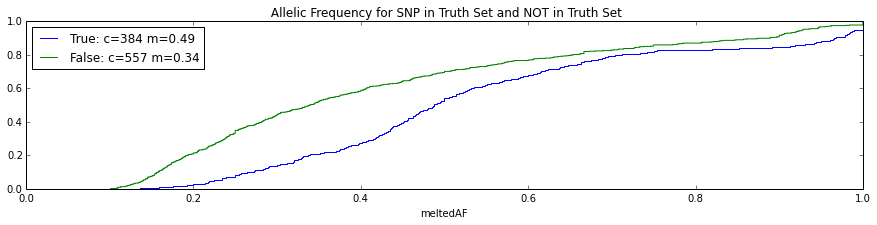

In [54]:
for truth in [True,False]:
    ser = dfSomatic[(dfSomatic['consensus']==True)&(dfSomatic['inPON']==False)&(dfSomatic.inTruth==truth)&(dfSomatic.variantType=='INDEL')]['meltedAF']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency for SNP in Truth Set and NOT in Truth Set",figsize=[15,3],xlim=[0,1])

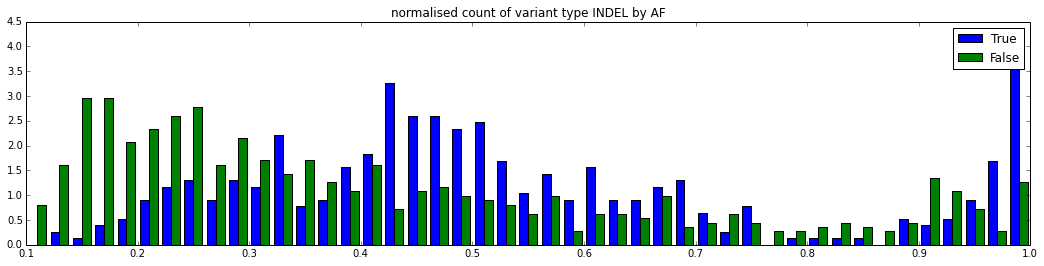

In [185]:
variantType = 'INDEL'
plt.figure(figsize=[18,4])
plt.hist([dfSomatic[(dfSomatic['consensus']==True)&(dfSomatic['inPON']==False)&(dfSomatic.inTruth==True)&
    (dfSomatic.variantType==variantType)]['meltedAF'].values,dfSomatic[(dfSomatic['consensus']==True)&
    (dfSomatic['inPON']==False)&(dfSomatic.inTruth==False)&(dfSomatic.variantType==variantType)]['meltedAF'].values],
    cumulative=False, normed=True, bins=50,range=(0.0,1.0),histtype='bar',stacked = False,rwidth=0.8,label=['True','False'])
plt.title('normalised count of variant type '+variantType+' by AF')
plt.legend()
plt.show()

### Load BAF and CNV and calculate median BAF per segment

In [92]:
dfBAF = createBAF(dfGermline)

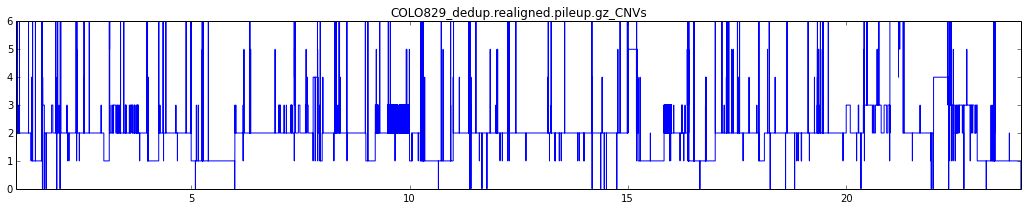

In [93]:
dfTumorCNV = loadCNVforPatient(PATH+tumorCNVFileName,patientID)
dfNormalCNV = loadCNVforPatient(PATH+normalCNVFileName,patientID)
dfTumorCNV['mBAF'], dfTumorCNV['mBAFCount'] = np.vectorize(calculateMBAFBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])
cnvChart(dfTumorCNV,tumorCNVFileName,1,24)

### TUMOR PURITY

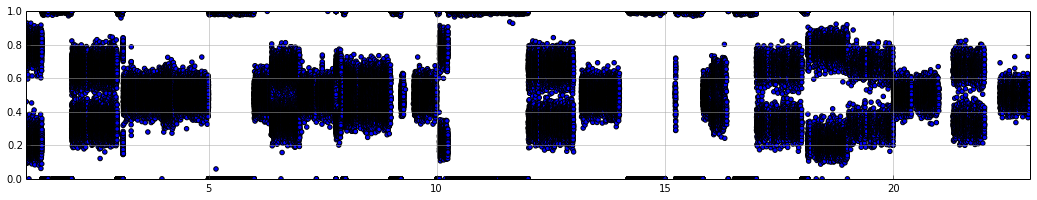

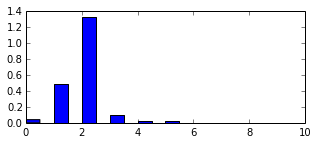

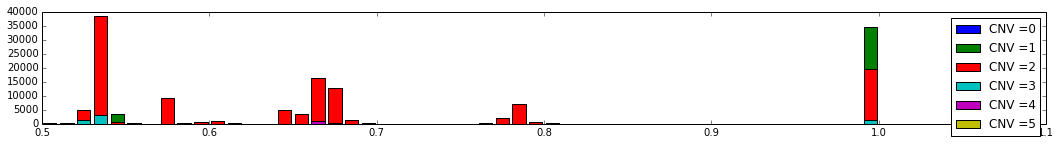

In [133]:
c,fractionMin,fractionMax = 1,0,22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfSom.chromPos, dfSom.BAF,c+fractionMin, c+fractionMax)
# CNV according to freeC
plt.figure(figsize=[5,2])
plt.hist(dfTumorCNV['copyNum'].values,cumulative=False, normed=True, bins=20,range=(0,10),weights=dfTumorCNV['regionLength'].values)
plt.show()
# should only use regions with mbaf > x
c,fractionMin,fractionMax = 1,0,22
dftemp = dfTumorCNV[(dfTumorCNV.mBAF>=0.0)&(dfTumorCNV.mBAF<=1.0)&(dfTumorCNV.mBAFCount>20)&(dfTumorCNV.chromPos<=c+fractionMax)&(dfTumorCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,2])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

In [134]:
dfTumorCNV[(dfTumorCNV.chrom>0)&(dfTumorCNV.copyNum>=1)&(dfTumorCNV.mBAF>0.56)&(dfTumorCNV.mBAF<0.62)\
      &(dfTumorCNV.mBAFCount>100)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
546,8,0,2,8.000000,2195000,0.574856,190
550,8,2557000,2,8.017470,36674999,0.574074,3239
552,8,39387000,2,8.269103,3704999,0.575758,175
569,8,47541000,2,8.324813,5188999,0.572816,193
571,8,52733000,2,8.360287,4021999,0.570714,276
575,8,58123000,2,8.397113,2011999,0.581017,152
577,8,60137000,2,8.410873,22616999,0.574257,1266
581,8,83296000,2,8.569102,61454999,0.572917,3803
2296,16,6152000,2,16.068087,489999,0.595960,109
2298,16,6650000,2,16.073599,985999,0.602938,350


### SOMATIC AF

In [96]:
#dfSomatic[(dfSomatic.consensus==True)&((dfSomatic.annWorstImpact=='MODERATE')|(dfSomatic.annWorstImpact=='HIGH'))]

In [99]:
pd.pivot_table(dfSomatic[dfSomatic.consensus==True], values='pos', index=['patientName','variantType','inPON'], columns=['inTruth'], aggfunc='count',margins=False).fillna("")

inTruth                        False  True 
patientName variantType inPON              
COLO829     INDEL       False    557    384
                        True    1237     13
            SNP         False   3886  35176
                        True     500     45

In [100]:
pd.pivot_table(dfSomatic[(dfSomatic.variantType == 'SNP')&(dfSomatic.consensus == True)&(dfSomatic.inPON == False)], values='pos', index=['ref'], columns=['meltedallele'], aggfunc='count',margins=True).fillna("")

meltedallele,A,C,G,T,All
ref,,,,,
A,,765,1137,830,2732.0
C,2035,,334,14031,16400.0
G,14536,344,,2200,17080.0
T,802,1189,859,,2850.0
All,17373,2298,2330,17061,39062.0


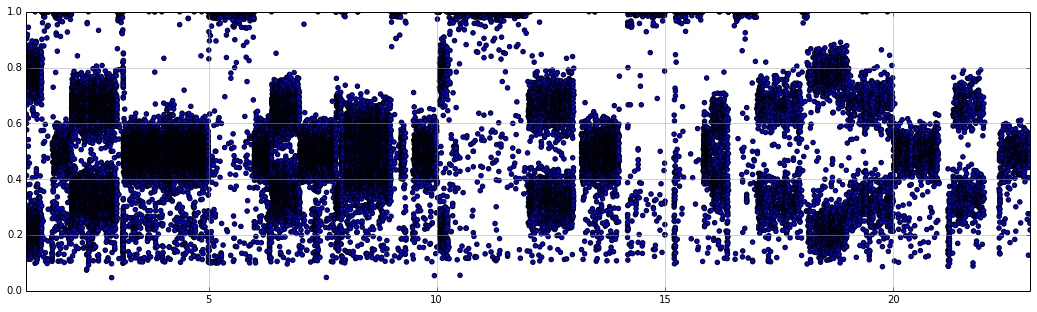

In [101]:
c,fractionMin,fractionMax = 1,0,22
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

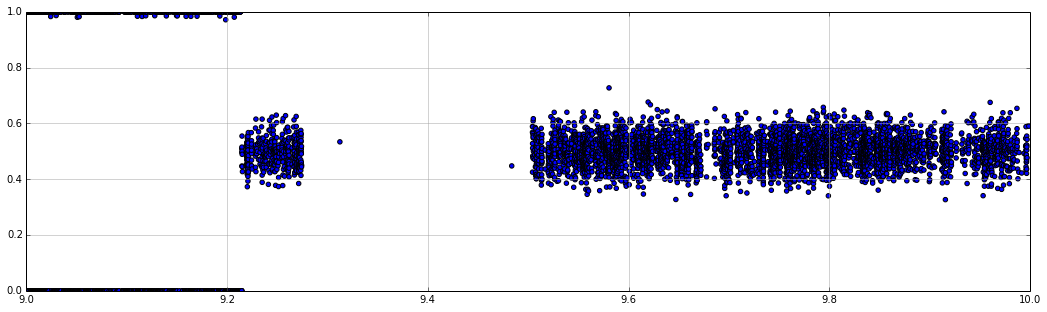

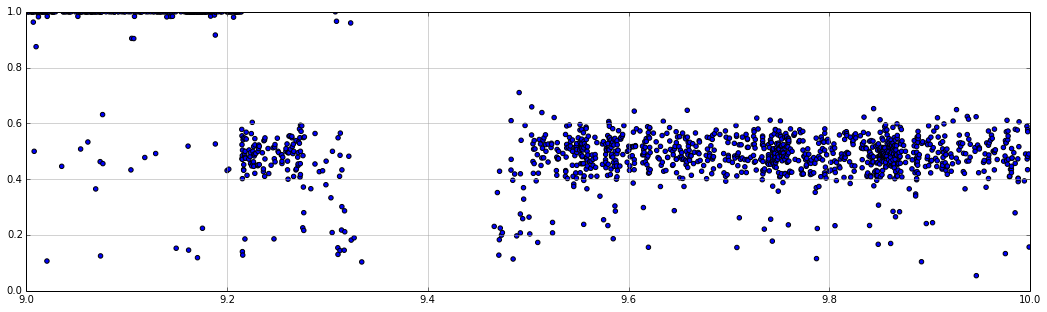

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
588,9,6595000,1,9.046702,23744000,1.000000,2174
988,9,103861000,2,9.735490,3736999,0.536585,326
1061,9,119660000,2,9.847370,3077999,0.530435,269


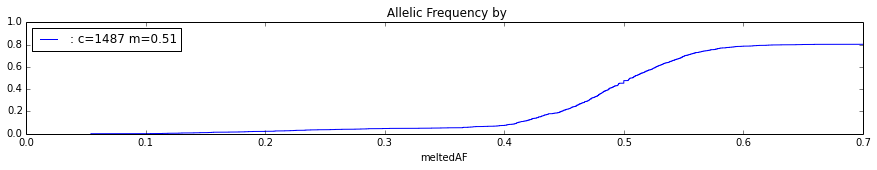

In [122]:
c,fractionMin,fractionMax = 9,0,1
dfTemp = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfTemp.chromPos, dfTemp.BAF,c+fractionMin, c+fractionMax)
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

#CDF
ser = dfSom.meltedAF.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,2],xlim=[0.0,0.7])

#mbaf
dfTumorCNV[(dfTumorCNV.chromPos>c+fractionMin)&(dfTumorCNV.chromPos<c+fractionMax)&(dfTumorCNV.mBAFCount>200)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

### Somatic Peak Finding

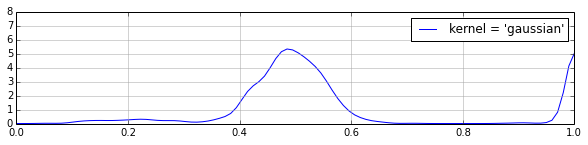

[0.05, 0.15, 0.22, 0.48, 0.7, 0.9]

In [103]:
X = dfSom.meltedAF.sort_values()[:, np.newaxis]
X_plot = np.linspace(0,1,100)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens)
findPeaks(log_dens,1)

### RATIO

In [104]:
dfTumorRatio = pd.read_table(PATH + tumorRatioFileName, header=0)#names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfNormalRatio = pd.read_table(PATH + normalRatioFileName, header=0)# names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfTumorRatio.set_index(['Chromosome','Start'],inplace=True)
dfNormalRatio.set_index(['Chromosome','Start'],inplace=True)
dfTumorRatio = pd.merge(dfTumorRatio,dfNormalRatio,how='inner', left_index=True,right_index=True)
#dfTumorRatio = dfTumorRatio[(dfTumorRatio.Ratio_y > 0)]
dfTumorRatio['ratio']= pd.to_numeric(dfTumorRatio['Ratio_x'],errors=coerce) /pd.to_numeric(dfTumorRatio['Ratio_y'],errors=coerce)
dfTumorRatio = dfTumorRatio.reset_index()
dfTumorRatio['chromPos'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x))) + \
    dfTumorRatio['Start']/dfTumorRatio['Chromosome'].map(lambda x: cd.chromosomeLength[str(x)])
dfTumorRatio['Chromosome'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x)))

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [105]:
dfTumorCNV['nonZeroCount'],dfTumorCNV['tumorRatio'],dfTumorCNV['normalRatio'] \
    ,dfTumorCNV['tumorMedianRatio'],dfTumorCNV['normalMedianRatio'] = \
    np.vectorize(nonZeroCountBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])
dfTumorCNV['ratioOfRatio']=dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio

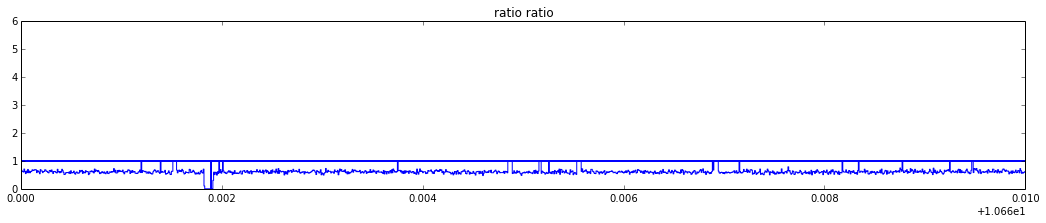

In [106]:
positionChart(dfTumorRatio,"ratio","ratio",10.66,10.67,6)

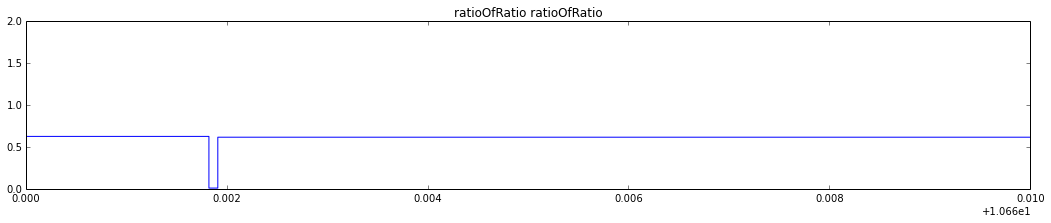

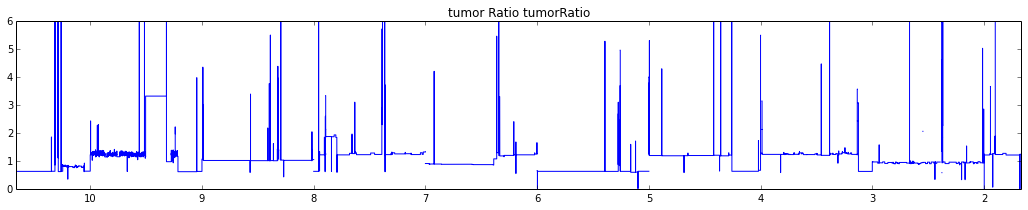

In [107]:
positionChart(dfTumorCNV,"ratioOfRatio","ratioOfRatio",10.66,10.67,2)
positionChart(dfTumorCNV,"tumor Ratio","tumorRatio",10.66,1.67,6)

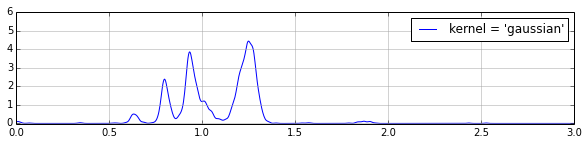

In [108]:
X = dfTumorCNV[dfTumorCNV.nonZeroCount>10].ratioOfRatio.sort_values()[:, np.newaxis]
X_range = 3
X_plot = np.linspace(0,X_range,1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens,6)
cnvPeaks = findPeaks(log_dens,X_range)

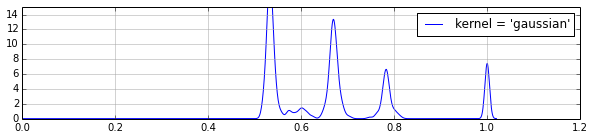

In [109]:
X = dfTumorCNV[dfTumorCNV.mBAFCount>10].mBAF.sort_values()[:, np.newaxis]
X_range = 1.02
X_plot = np.linspace(0,X_range,1020)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.005).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens,15)
mBAFPeaks = findPeaks(log_dens,X_range)

In [110]:
dfTumorCNV['fittedBAFPeak'] = np.vectorize(fitBAFPeak)(dfTumorCNV['mBAF'])
dfTumorCNV['fittedCNVPeak'] = np.vectorize(fitCNVPeak)(dfTumorCNV['ratioOfRatio'])
pd.pivot_table(dfTumorCNV, values='mBAFCount', index=['fittedBAFPeak'], columns=['fittedCNVPeak'], aggfunc='sum',margins=True).fillna("")

fittedCNVPeak,0.009,0.066,0.342,0.519,0.531,0.63,0.795,0.93,1.008,1.245,1.395,1.533,1.569,1.782,1.839,1.866,1.896,2.43,2.523,All
fittedBAFPeak,,,,,,,,,,,,,,,,,,,,
0.532,1,0,0,0,0,3393,0,0,6962,44188,170,3,4,0,,0,0,,0,54721.0
0.574,,,,,,157,,,9946,233,15,1,,,,,,,,10352.0
0.601,4,,,,,,,8,2052,24,2,1,,1,,,,,,2092.0
0.669,2,,,,,,,36296,3345,7,,,,16,246,556,321,,,40789.0
0.748,,,,,,,256,14,9,1,,,,,,,1,66,,347.0
0.782,,,,,,,10519,1,,,,,,,,,,,89,10609.0
0.999,3,,,56,,34631,1,12884,1604,6604,,,,,24,,,,,55807.0
All,10,0,0,56,0,38181,10776,49203,23918,51057,187,5,4,17,270,556,322,66,89,174717.0


### GENE CNV ANALYSIS

In [111]:
# BEST ESTIMATE OF COPY NUMBER!
dfTumorCNV["myCopyNum"] = np.round(dfTumorCNV.fittedCNVPeak/0.63*2,0)

In [112]:
# LOAD CNV BED
CNV_BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
CNV_BED_FILE_NAME = BED_FILE_NAME
CNVBed = aVCF.loadBEDFile(CNV_BED_PATH,CNV_BED_FILE_NAME)

In [113]:
dfGeneCNV = pd.DataFrame(runGeneCNVAnalysis(dfTumorCNV,CNVBed,'COLO829'),columns= GENECNV_COLUMNS)

In [114]:
(dfGeneCNV[dfGeneCNV.minCopyNum>3])

,patientName,gene,chrom,posStart,posEnd,minCopyNum,cnvLabel
2,COLO829,ENST00000524377.1 (NTRK1),1,156830686,156851434,4.0,amplification
15,COLO829,ENST00000231790.2 (MLH1),3,37034823,37092409,4.0,amplification
16,COLO829,ENST00000349496.5 (CTNNB1),3,41240930,41281936,4.0,amplification
17,COLO829,ENST00000296474.3 (MST1R),3,49924435,49941070,4.0,amplification
18,COLO829,ENST00000477593.1 (PIK3CB),3,138372860,138553594,4.0,amplification
19,COLO829,ENST00000350721.4 (ATR),3,142168079,142297668,4.0,amplification
20,COLO829,ENST00000263967.3 (PIK3CA),3,178866311,178957881,4.0,amplification
22,COLO829,ENST00000257290.5 (PDGFRA),4,55095264,55164414,4.0,amplification
23,COLO829,ENST00000288135.5 (KIT),4,55524085,55606881,4.0,amplification
24,COLO829,ENST00000263923.4 (KDR),4,55944644,55991756,4.0,amplification


In [115]:
dfSomatic[(dfSomatic.annWorstImpact=='HIGH')&(dfSomatic.bedRegion=='')].sort_values('annGene')

,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,meltedallele,meltedAF,meltedDP,meltedQS,meltedSGT,meltedindelDiff,meltedSVLenMin,meltedSVLenMax,meltedSVStartMin,meltedSVStartMax,patientName,alt,truthDP,truthAF,inTruth,PONCount,inPON
12434,2,215940307,2:215940307,2.887915,.,C,Intersection,4,SNP,,PASS,,False,False,ABCA12,HIGH,stop_gained,stop_gained|intron_variant,True,T,0.621359,104,-1.0,0/1,,,,,,COLO829,T,102,0.617647,True,0,False
12111,2,202580492,2:202580492,2.832981,COSM25296,G,Intersection,4,SNP,,PASS,,False,True,ALS2,HIGH,stop_gained,stop_gained|3_prime_UTR_variant|3_prime_UTR_va...,True,A,0.764151,106,-1.0,0/1,,,,,,COLO829,A,108,0.768519,True,0,False
41291,9,38573127,9:38573127,9.273155,COSM36880,C,Intersection,4,SNP,,PASS,,False,True,ANKRD18A,HIGH,splice_acceptor_variant&intron_variant,splice_acceptor_variant&intron_variant|splice_...,True,T,0.455696,158,-1.0,0/1,,,,,,COLO829,T,160,0.468750,True,0,False
7345,2,21233814,2:21233814,2.087310,COSM36732,C,Intersection,4,SNP,,PASS,,False,True,APOB,HIGH,stop_gained,stop_gained,True,A,0.356436,102,-1.0,0/1,,,,,,COLO829,A,103,0.359223,True,0,False
16088,3,121305072,3:121305072,3.612582,COSM36660,G,Intersection,4,SNP,,PASS,,False,True,ARGFX,HIGH,stop_gained,stop_gained,True,A,0.528846,103,-1.0,0/1,,,,,,COLO829,A,102,0.529412,True,0,False
68,1,1418472,1:1418472,1.005691,COSM36824,A,Intersection,4,SNP,,PASS,,False,True,ATAD3B,HIGH,stop_gained,stop_gained|sequence_feature|intron_variant|in...,True,T,0.246575,73,-1.0,0/1,,,,,,COLO829,T,NaN,NaN,False,0,False
12500,2,220088487,2:220088487,2.904971,rs78447143;COSM36736,C,Intersection,4,SNP,,PASS,,True,True,ATG9A,HIGH,splice_acceptor_variant&intron_variant,splice_acceptor_variant&intron_variant|splice_...,True,T,0.500000,88,-1.0,0/1,,,,,,COLO829,T,86,0.500000,True,0,False
7577,2,32733148,2:32733148,2.134594,COSM36763,C,Intersection,4,SNP,,PASS,,False,True,BIRC6,HIGH,stop_gained,stop_gained,True,T,0.309524,84,-1.0,0/1,,,,,,COLO829,T,84,0.297619,True,0,False
27979,5,180375375,5:180375375,5.997016,rs10541574;COSM243261,GGTAA,freebayes,1,INDEL,DELETE,.,,True,True,BTNL8,HIGH,splice_donor_variant&splice_region_variant&int...,splice_donor_variant&splice_region_variant&int...,False,G,1.000000,4,-1.0,1/1,GTAA-,,,,,COLO829,G,NaN,NaN,False,265,True
6460,1,243328887,1:243328887,1.976242,rs199575184;COSM228300,G,mutect,1,SNP,,PASS,,True,True,CEP170,HIGH,stop_gained,stop_gained|stop_gained|stop_gained|stop_gaine...,False,T,0.043860,114,-1.0,0/1,,,,,,COLO829,T,NaN,NaN,False,123,True


### SV Analysis

In [116]:
svVCFFilename = findFiles(PATH,"somaticSV.vcf")[0]
print "SV =",svVCFFilename
dfSV = loadVCF(PATH,svVCFFilename,{patientID:'tumor'},patientID)

SV = somaticSV.vcf
reading vcf file: somaticSV.vcf
reading VCF File line: 1
Number variants loaded: 118


In [117]:
pd.pivot_table(dfSV[(dfSV.variantSubType<>"IGN")&(dfSV.tumorAF>=0.08)], values='id', index=['variantSubType'], columns=['variantType'], aggfunc='count').fillna("")

variantType,SV
variantSubType,
BND,20
DEL,25
DUP,11
INV,7


In [118]:
dfSV[(dfSV.bedRegion<>"A")&(dfSV.variantSubType=="DUP")&(dfSV.tumorAF>=0.08)][['chrom','pos','chromFrac','variantSubType','bedRegion','tumorallele','tumorAF','tumorSGT','tumorSVLenMin','tumorSVLenMax','tumorSVStartMin','tumorSVStartMax']]

,chrom,pos,chromFrac,variantSubType,bedRegion,tumorallele,tumorAF,tumorSGT,tumorSVLenMin,tumorSVLenMax,tumorSVStartMin,tumorSVStartMax
4,1,224646602,1.901288,DUP,,<DUP:TANDEM>,0.241803,185,153518,153518,224646602,224646602
35,7,85844667,7.539433,DUP,,<DUP:TANDEM>,0.158371,186,9033,9033,85844667,85844667
36,7,104485066,7.656566,DUP,,<DUP:TANDEM>,0.257246,205,127232,127236,104485066,104485068
43,8,131248061,8.896724,DUP,,<DUP:TANDEM>,0.108527,115,26128,27084,131247835,131248288
76,15,41621291,15.405937,DUP,,<DUP:TANDEM>,0.563910,"58,",7211,7219,41621291,41621295
105,Y,3253034,24.054789,DUP,,<DUP:TANDEM>,1.000000,"0,3",695,1213,3252905,3253164
109,Y,8240864,24.138797,DUP,,<DUP:TANDEM>,1.000000,"0,5",171,835,8240698,8241031
110,Y,9842433,24.165771,DUP,,<DUP:TANDEM>,1.000000,"0,5",400,1207,9842287,9842579
114,Y,16912361,24.284847,DUP,,<DUP:TANDEM>,1.000000,"0,4",2646,3408,16912171,16912552
115,Y,18106199,24.304954,DUP,,<DUP:TANDEM>,1.000000,"0,3",3030,3609,18106055,18106344


In [119]:
def findMatchingBNDChromPos(df):
    # can 
    df['BNDMatchPos'] = ""
    for i in range(0,df.shape[0]):
        if df.iloc[i]['variantSubType'] == "BND":
            tmp = df.iloc[i]['tumorallele'].find("]")
            if tmp >= 0:
                df.iloc[i,df.columns.get_loc('BNDMatchPos')] = df.iloc[i]['tumorallele'][tmp+1:df.iloc[i]['tumorallele'].find("]",tmp+1)]
    return df

In [120]:
dfSV = findMatchingBNDChromPos(dfSV)

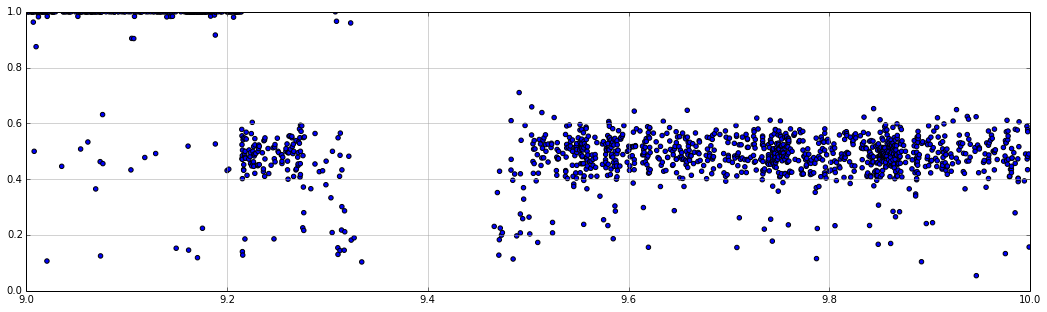

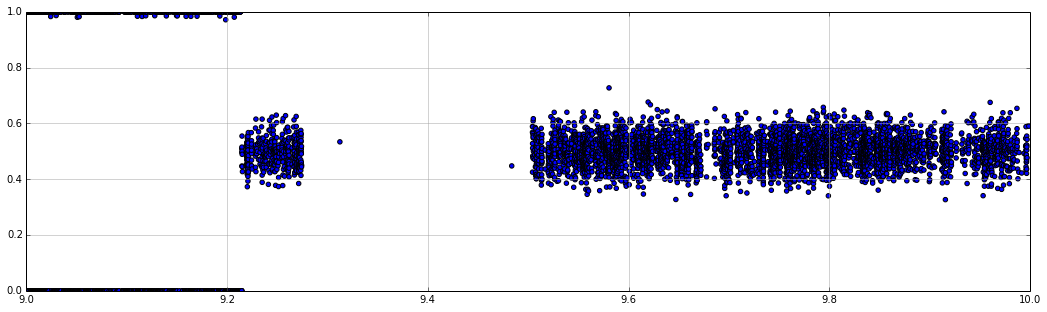

In [121]:
c,fractionMin,fractionMax = 9,0,1
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)
dfTemp = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfTemp.chromPos, dfTemp.BAF,c+fractionMin, c+fractionMax)

In [147]:
dfSV[(dfSV.variantSubType=="INS")&(dfSV.tumorAF>=0.08)][['chrom','pos','chromFrac','variantSubType','bedRegion','BNDMatchPos','tumorallele','tumorAF','tumorDP','tumorSGT','tumorSVLenMin','tumorSVLenMax','tumorSVStartMin','tumorSVStartMax']]

,chrom,pos,chromFrac,variantSubType,bedRegion,BNDMatchPos,tumorallele,tumorAF,tumorDP,tumorSGT,tumorSVLenMin,tumorSVLenMax,tumorSVStartMin,tumorSVStartMax
